In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd drive/My Drive/colab_notebooks/pose_estimation

## Imports

In [2]:
import json
import requests
import zipfile
import torch
import os
import numpy as np
from torch.utils import data
from torchvision import transforms
from PIL import Image
from io import BytesIO
from collections import OrderedDict
from generate_cmap_paf import generate_cmap, generate_paf, generate_topology_independent_paf, annotations_to_connections, annotations_to_peaks

## Configs

In [3]:
from pose_datasets import FootOnlyConfig, BodyAndFeetConfig, BodyOnlyConfig

## Datasets


In [4]:
from pose_datasets import FootPoseDataset, HandPoseDataset

## Transforms

In [5]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return torch.clamp(tensor + torch.randn(tensor.size()) * self.std + self.mean, 0, 1)
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [6]:
class RandomCrop(object):
    """
    Probabilistic random crop. With a probability p randomly crops the image.
    """
    
    def __init__(self, min_scale=0.2, max_scale=1.0, p=1.0):
        self.min_scale = min_scale
        self.max_scale = max_scale
        self.p = p
        
    def __call__(self, img, keypoints):
        if np.random.rand() > self.p:
            # with probability 1-p do not crop
            return img, keypoints
        
        width, height = img.size

        # with probability p do crop
        scale = np.random.uniform(self.min_scale, self.max_scale)
        crop_width = width * scale
        crop_height = height * scale

        left = np.random.uniform(0, width - crop_width)
        top = np.random.uniform(0, height - crop_height)
        right = left + crop_width
        bottom = top + crop_height
        img_cropped = img.crop((left, top, right, bottom))
        
        # rescale to original size
        img_rescaled = img_cropped.resize((width, height))
        
        # update annotations
        keypoints[..., 0] -= left / width
        keypoints[..., 0] /= scale
        keypoints[..., 1] -= top / height
        keypoints[..., 1] /= scale
        
        # remove out of bounds keypoints
        keypoints[torch.any(keypoints[..., 0:2] < 0, axis=2)] = 0
        keypoints[torch.any(keypoints[..., 0:2] > 1, axis=2)] = 0
        
        return img_rescaled, keypoints
    
    def __repr__(self):
        return self.__class__.__name__ + '(min_scale={0}, max_scale={1}, p={2})'.format(self.min_scale, self.max_scale, self.p)

In [7]:
def init_model_to_transfer_learning(pretrained_model, num_parts, num_links, num_upsample=3):
    """
    1. Disable backpropagation for the backbone
    2. Initialze the pretrained model by leaving the backbone's weights unchanged
    and resetting weights and output shape of the the paf and cmap extractors
    """

    # disable backpropagation for the backbone
    # for param in pretrained_model[0].parameters():
    #     param.requires_grad = False

    # # # disable batch normalization for the backbone
    # for m in pretrained_model[0].modules():
    #     if isinstance(m, torch.nn.BatchNorm2d):
    #         m.eval()

    feature_channels = 512
    new_cmap_channels = num_parts
    new_paf_channels = 2 * num_links
    upsample_channels = 256
    num_flat = 0

    # initialize new cmap and paf extractor
    new_cmap_paf_layer = CmapPafHeadAttention(feature_channels, new_cmap_channels, new_paf_channels, upsample_channels, num_upsample=num_upsample, num_flat=num_flat)

    # put the new extractor in the model instead of the old pretrained one
    pretrained_model[1] = new_cmap_paf_layer
    

## Training

In [8]:
import time
import copy

def train_model(model, criterion, optimizer, train_only=False, metric=None, scheduler=None, stdev_scheduler=None, window_scheduler=None, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('Inf')

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        phases = ['train'] if train_only else ['train', 'val']

        # Each epoch has a training and validation phase
        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # schedule heatmap standard deviation
            if stdev_scheduler is not None:
                new_stdev = stdev_scheduler(epoch)
                print('Setting %s dataset stdev to %s' % (phase, new_stdev))
                dataloaders[phase].dataset.set_stdev(new_stdev)

                # if new_stdev <= 1.0:
                #     print('Setting kernel type to pinpoint')
                #     dataloaders[phase].dataset.set_kernel_type('pinpoint')

            # schedule heatmap window size
            if window_scheduler is not None:
                new_window = window_scheduler(epoch)
                print('Setting %s dataset window to %s' % (phase, new_window))
                dataloaders[phase].dataset.set_window(new_window)

            running_loss = 0.0
            running_corrects = 0

            sample_count = 0
            # Iterate over data.
            for inputs, cmaps, pafs in dataloaders[phase]:
                inputs = inputs.to(device)
                cmaps = cmaps.to(device)
                pafs = pafs.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    cmap_loss = criterion(outputs[0], cmaps)
                    paf_loss = criterion(outputs[1], pafs)
                    cmap_metric = metric(outputs[0], cmaps)
                    paf_metric = metric(outputs[1], pafs)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        cmap_loss.backward(retain_graph=True)
                        paf_loss.backward()
                        optimizer.step()

                    sample_count += inputs.size(0)
                    if sample_count % (inputs.size(0) * 4) == 0:
                        status_line = '{}, after {} samples, batch cmap loss: {:.6f}, batch paf loss: {:.6f}'.format(phase, sample_count, cmap_loss, paf_loss)
                        if metric is not None:
                            status_line += ', batch cmap metric: {:.6f}, batch paf metric: {:.6f}'.format(cmap_metric, paf_metric)

                        print(status_line)


                # measure running loss as the average between cmap and paf loss
                running_loss += cmap_loss.item() + paf_loss.item() * inputs.size(0) / 2.0

            if scheduler is not None and phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / sample_count

            print('{} Loss: {:.6f}'.format(
                phase, epoch_loss))

            # deep copy the model
            eval_phase = 'train' if train_only else 'val'
            if phase == eval_phase and epoch_loss < best_loss:
                print('Updating best model weights')
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:6f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [9]:
def sum_of_squared_errors(output, target):
    loss = torch.sum((output - target)**2) / output.shape[0]
    return loss

def mse_punish_false_negative(output, target):
    # same as MSE but with false negatives punished harder
    weights = torch.ones_like(target)
    weights[(target >= 0.1)] = 3

    return torch.mean(weights * (output - target)**2)

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
import json
train_data_path = 'datasets/body_and_foot_pose/person_keypoints_train2017_foot_v1.json'
val_data_path = 'datasets/body_and_foot_pose/person_keypoints_val2017_foot_v1.json'

with open(train_data_path) as json_file:
    train_keypoints = json.load(json_file)
with open(val_data_path) as json_file:
    val_keypoints = json.load(json_file)

In [12]:
from torchvision import transforms

dataset_config = BodyAndFeetConfig(output_width=56, output_height=56)

train_dataset = FootPoseDataset(train_data_path, mode='train', config=dataset_config, transform=transforms.Compose([
                                                                        #    transforms.Resize((224, 224)),
                                                                           transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
                                                                           transforms.ToTensor(),
                                                                           transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                                                           ]), img_transform=[RandomCrop(p=0.5)], source='zip', use_cache=False,
                                                                           topology_independent=True)
val_dataset = FootPoseDataset(train_data_path, mode='train', config=dataset_config, transform=transforms.Compose([
                                                                        #    transforms.Resize((224, 224)),
                                                                           transforms.ToTensor(),
                                                                           transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                                                           ]), source='zip', use_cache=False, topology_independent=True)

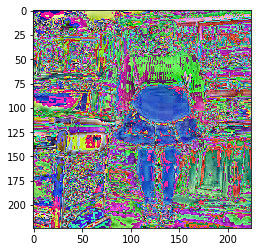

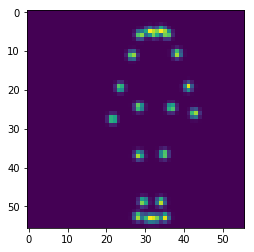

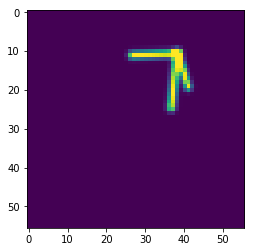

In [25]:
import torch
import matplotlib.pyplot as plt
from generate_cmap_paf import generate_cmap, generate_paf, annotations_to_connections, annotations_to_peaks

train_dataset.set_stdev(1)
#train_dataset.set_kernel_type('pinpoint')
#train_dataset.set_window(9.0)

ind = 19
img_raw, ann = train_dataset.get_image_and_annotation_data(ind)
img, cmap, paf = train_dataset[ind]
pil_tf = transforms.ToPILImage()
plt.imshow(pil_tf(img))
plt.show()

plt.imshow(torch.clamp(torch.sum(cmap, axis=0), 0, 1))
plt.show()
plt.imshow(torch.clamp(torch.sum(paf, axis=0), -1, 1))
plt.imshow(paf[5], vmin=0, vmax=1)
plt.show()

In [ ]:
# rc = RandomCrop()
# img_cropped, ann_cropped = rc(img_raw, ann)
# print(ann_cropped)
print(ann)

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler

nsamples = len(train_dataset)
train_val_split = nsamples - 500

sample_permutation = torch.randperm(nsamples)
train_range = list(range(train_val_split))
val_range = list(range(train_val_split, nsamples))

train_sampler = SubsetRandomSampler(sample_permutation[train_range])
val_sampler = SubsetRandomSampler(sample_permutation[val_range])

dataloaders = {
    'train': data.DataLoader(train_dataset, batch_size=32, num_workers=4, sampler=train_sampler),
    'val': data.DataLoader(val_dataset, batch_size=32, num_workers=4, sampler=val_sampler)
}
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

In [ ]:
from common import *
from resnet import resnet18_baseline_att
from torch.optim import lr_scheduler

# load the pre-trained model for COCO annotations
model = resnet18_baseline_att(18, 2 * 21).to(device)
model_weights_path = 'resnet18_baseline_att_224x224_A_epoch_249.pth'
model.load_state_dict(torch.load(model_weights_path, map_location=torch.device(device)))

In [ ]:
init_model_to_transfer_learning(model, train_dataset.config.num_parts, train_dataset.config.num_links, num_upsample=3)

In [ ]:
criterion = torch.nn.MSELoss()
metric = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
num_epochs = 25
stdev_scheduler = lambda ep: max((20 - ep) / 4 + 1.0, 1.0)
model = train_model(model.to(device), criterion, optimizer, metric=metric, num_epochs=num_epochs, train_only=False,
                    scheduler=None, stdev_scheduler=stdev_scheduler)

In [ ]:
train_dataset_unnormed = FootPoseDataset(train_data_path, mode='train', config=dataset_config, transform=transforms.Compose([
                                                                           transforms.Resize((224, 224)),
                                                                           transforms.ToTensor()
                                                                           ]), source='zip')
val_dataset_unnormed = FootPoseDataset(val_data_path, mode='val', config=dataset_config, transform=transforms.Compose([
                                                                           transforms.Resize((224, 224)),
                                                                           transforms.ToTensor()
                                                                           ]), source='zip')

In [ ]:
import matplotlib.pyplot as plt

ind = 0
img_ind = 19
# img_mean_inv = torch.Tensor([0.485, 0.456, 0.406]).reshape(-1, 1, 1)
# img_std_inv = torch.Tensor([0.229, 0.224, 0.225]).reshape(-1, 1, 1)
# img_if = img * img_std_inv ** 2 + img_mean_inv
img_orig, cmap, paf = train_dataset_unnormed[img_ind]
tf = transforms.ToPILImage()
plt.imshow(tf(img_orig))
plt.show()

print(cmap.shape)

img, cmap, paf = train_dataset[img_ind]
plt.imshow(torch.sum(cmap, axis=0), vmin=0, vmax=1)
plt.show()

cmap_inf, paf_inf = model(img.reshape(1, *img.shape).to(device))
cmap_inf = cmap_inf.detach().cpu()
paf_inf = paf_inf.detach().cpu()
plt.imshow(torch.sum(cmap_inf[0], axis=0), vmin=0, vmax=1.0)
# plt.imshow(cmap_inf[0, 5], vmin=0, vmax=1.0)
plt.show()
#cmap_ae = torch.sum(torch.abs(cmap_inf[0, ind] - cmap[ind]))
#print(torch.max(cmap[ind]))
#print(torch.max(cmap_inf[0][ind]))
#print(cmap_ae)

In [ ]:
model = train_model(model.to(device), criterion, optimizer, metric=metric, num_epochs=5, train_only=False,
                    scheduler=None, stdev_scheduler=lambda ep: 1.0)

In [ ]:
torch.save(model.state_dict(), 'body_only_25ep.pth')

In [ ]:
model_orig = resnet18_baseline_att(18, 2 * 21).to(device)
model_weights_path = 'resnet18_baseline_att_224x224_A_epoch_249.pth'
model_orig.load_state_dict(torch.load(model_weights_path))

In [ ]:
import matplotlib.pyplot as plt

ind = 0
img_ind = 14

img_orig, cmap, paf = val_dataset_unnormed[img_ind]
tf = transforms.ToPILImage()
plt.imshow(tf(img_orig))
plt.show()

img, cmap, paf = val_dataset[img_ind]
cmap_inf, paf_inf = model_orig(img.reshape(1, *img.shape).to(device))

# for i in range(len(cmap_inf[0])):
#     cmap_inf = cmap_inf.detach().cpu()
#     plt.imshow(cmap_inf[0, i], vmin=0, vmax=1.0)
#     plt.show()

for i in range(len(paf_inf[0])):
    paf_inf = paf_inf.detach().cpu()
    plt.imshow(paf_inf[0, i], vmin=0, vmax=1.0)
    plt.show()

In [ ]:
train_keypoints['categories']